In [1]:
import sys
from pathlib import Path

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root / "src"))

from dijon.chromagram import metric_chromagram
from dijon.global_config import DERIVED_DIR, RAW_AUDIO_DIR
from dijon.notebook_ui import display_audio_with_cursor
from dijon.utils.audio_region import resolve_audio_region

%matplotlib inline

In [2]:
def load_audio_region(
    track_name: str,
    *,
    start_marker: str = "",
    end_marker: str = "",
) -> tuple[np.ndarray, int, float, float]:
    """Load mono audio for a full track or marker-defined sub-region."""
    audio_path = RAW_AUDIO_DIR / f"{track_name}.wav"
    assert audio_path.exists(), f"Audio not found: {audio_path}"

    if start_marker or end_marker:
        start_sec, end_sec = resolve_audio_region(
            audio_path,
            start_marker=start_marker or None,
            end_marker=end_marker or None,
        )
    else:
        start_sec = 0.0
        end_sec = librosa.get_duration(path=str(audio_path))

    duration = end_sec - start_sec
    y, sr = librosa.load(
        audio_path,
        sr=None,
        mono=True,
        offset=start_sec,
        duration=duration,
    )
    return y, sr, start_sec, end_sec


def load_meter_region(
    track_name: str,
    *,
    start_sec: float,
    end_sec: float,
) -> np.ndarray:
    """Load meter map and rebase region times to start at 0."""
    meter_path = DERIVED_DIR / "meter" / f"{track_name}_meter.npy"
    assert meter_path.exists(), (
        f"Meter map not found: {meter_path}\n"
        "Run the meter pipeline first: dijon meter"
    )

    meter_map = np.load(meter_path).astype(np.float64)
    assert meter_map.ndim == 2 and meter_map.shape[1] == 3, (
        f"Expected meter_map shape (N, 3), got {meter_map.shape}"
    )

    mask = (meter_map[:, 0] >= start_sec) & (meter_map[:, 0] <= end_sec)
    meter_region = meter_map[mask].copy()
    assert meter_region.size > 0, "No meter entries in selected region"
    meter_region[:, 0] -= start_sec
    return meter_region

In [3]:
def compute_metric_chromagram_for_track(
    track_name: str,
    *,
    start_marker: str = "",
    end_marker: str = "",
    hop_length: int = 256,
    chroma_type: str = "cqt",
    bpm_threshold: float = 180.0,
    aggregate: str = "mean",
    accent_mode: str = "preserve",
) -> tuple[np.ndarray, np.ndarray, int, dict]:
    """Load inputs and compute metric chromagram."""
    y, sr, start_sec, end_sec = load_audio_region(
        track_name,
        start_marker=start_marker,
        end_marker=end_marker,
    )
    meter_map = load_meter_region(track_name, start_sec=start_sec, end_sec=end_sec)

    C_metric = metric_chromagram(
        y,
        sr=sr,
        meter_map=meter_map,
        hop_length=hop_length,
        chroma_type=chroma_type,
        bpm_threshold=bpm_threshold,
        aggregate=aggregate,
        accent_mode=accent_mode,
    )

    info = {
        "track_name": track_name,
        "start_sec": start_sec,
        "end_sec": end_sec,
        "duration": end_sec - start_sec,
        "sr": sr,
        "meter_rows": meter_map.shape[0],
        "chroma_shape": C_metric.shape,
    }
    return C_metric, y, sr, info


def show_chromagram_with_audio(
    C_metric: np.ndarray,
    y: np.ndarray,
    sr: int,
    *,
    track_name: str,
    chroma_type: str,
    hop_length: int,
) -> None:
    """Display chromagram and synchronized audio player."""
    fig, ax = plt.subplots(figsize=(14, 4))
    img = librosa.display.specshow(
        C_metric,
        x_axis="frames",
        y_axis="chroma",
        hop_length=hop_length,
        sr=sr,
        ax=ax,
        cmap="magma",
    )
    ax.set_title(f"{track_name} — Metric Chromagram ({chroma_type})")
    ax.set_xlabel("Metric subdivision")
    fig.colorbar(img, ax=ax, format="%.2f", pad=0.02)
    plt.tight_layout()

    display_audio_with_cursor(y, sr, fig=fig, ax=ax, close_fig=True, max_duration_sec=600)


def sweep_chroma_tuning(
    *,
    track_name: str,
    start_marker: str = "",
    end_marker: str = "",
    chroma_types: tuple[str, ...] = ("cqt", "stft"),
    hop_lengths: tuple[int, ...] = (128, 256, 512),
    bpm_threshold: float = 180.0,
    aggregate: str = "mean",
    accent_mode: str = "preserve",
) -> dict[str, np.ndarray]:
    """Compute chromagrams across chroma backends / hop lengths for one marker region."""
    # Resolve marker-based region via load_audio_region -> resolve_audio_region.
    y, sr, start_sec, end_sec = load_audio_region(
        track_name,
        start_marker=start_marker,
        end_marker=end_marker,
    )
    meter_map = load_meter_region(track_name, start_sec=start_sec, end_sec=end_sec)

    sweep_results: dict[str, np.ndarray] = {}
    for chroma_type in chroma_types:
        for hop_length in hop_lengths:
            key = f"{chroma_type}_H{hop_length}"
            C_metric = metric_chromagram(
                y,
                sr=sr,
                meter_map=meter_map,
                hop_length=hop_length,
                chroma_type=chroma_type,
                bpm_threshold=bpm_threshold,
                aggregate=aggregate,
                accent_mode=accent_mode,
            )
            sweep_results[key] = C_metric
            print(f"{key}: {C_metric.shape}")

    return sweep_results

In [4]:
def run_chromagram_notebook(
    *,
    track_name: str,
    start_marker: str = "",
    end_marker: str = "",
    hop_length: int = 256,
    chroma_type: str = "cqt",
    bpm_threshold: float = 180.0,
    aggregate: str = "mean",
    accent_mode: str = "preserve",
) -> dict:
    """Compute, report, and display metric chromagram for one track."""
    C_metric, y, sr, info = compute_metric_chromagram_for_track(
        track_name,
        start_marker=start_marker,
        end_marker=end_marker,
        hop_length=hop_length,
        chroma_type=chroma_type,
        bpm_threshold=bpm_threshold,
        aggregate=aggregate,
        accent_mode=accent_mode,
    )

    print(
        f"{info['track_name']}  region [{info['start_sec']:.2f}s - {info['end_sec']:.2f}s]  "
        f"dur={info['duration']:.2f}s  sr={info['sr']} Hz"
    )
    print(f"Meter rows: {info['meter_rows']}")
    print(
        f"Chromagram shape: {info['chroma_shape']}  "
        f"(12 pitch classes x {info['chroma_shape'][1]} metric bins)"
    )

    show_chromagram_with_audio(
        C_metric,
        y,
        sr,
        track_name=track_name,
        chroma_type=chroma_type,
        hop_length=hop_length,
    )
    return info

YTB-008  region [6.78s - 17.21s]  dur=10.44s  sr=22050 Hz
Meter rows: 32
Chromagram shape: (12, 76)  (12 pitch classes x 76 metric bins)



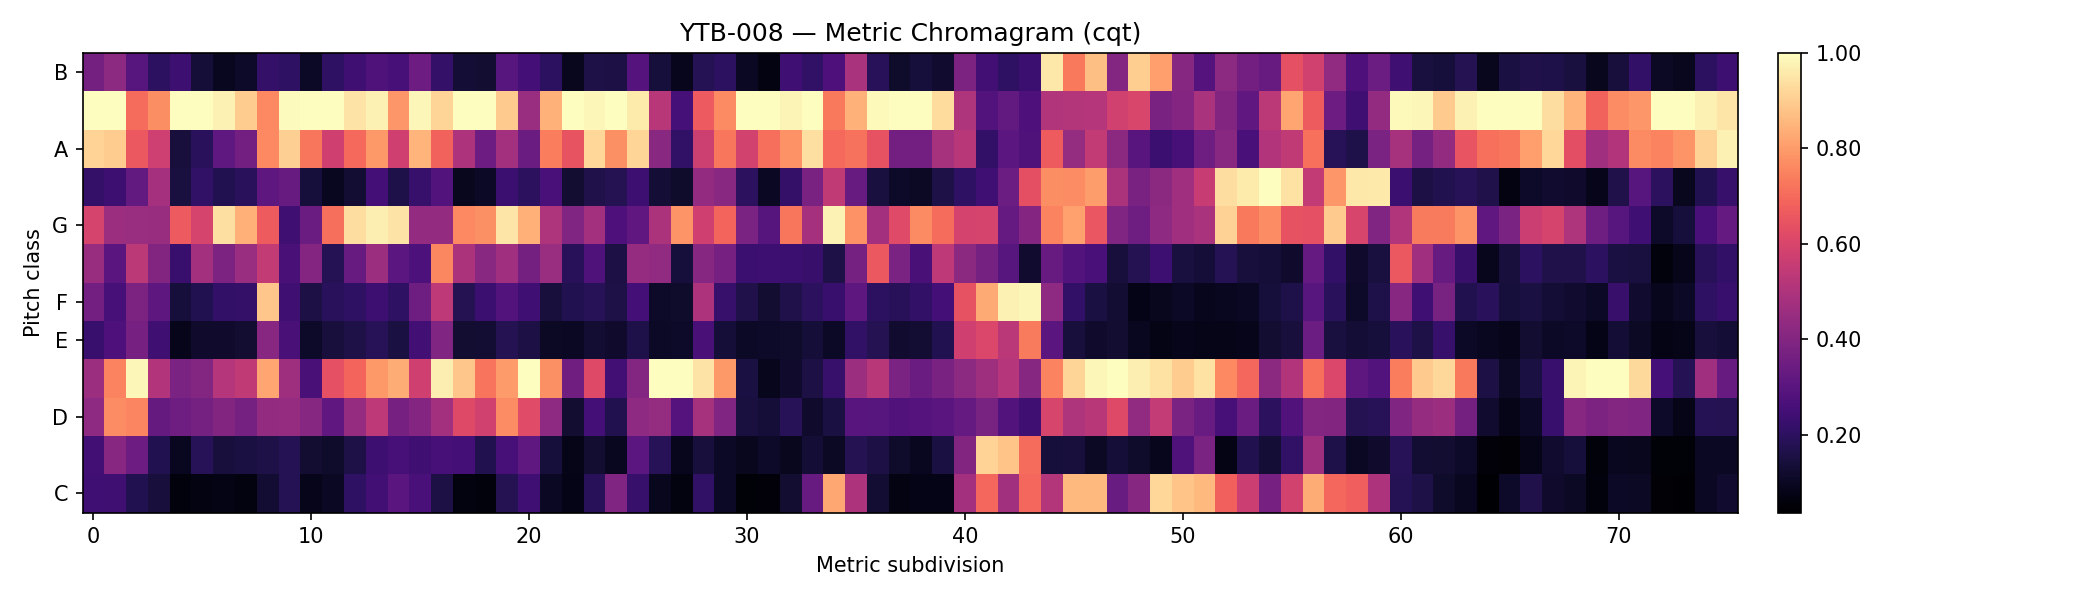

YTB-008  region [6.78s - 17.21s]  dur=10.44s  sr=22050 Hz
Meter rows: 32
Chromagram shape: (12, 76)  (12 pitch classes x 76 metric bins)



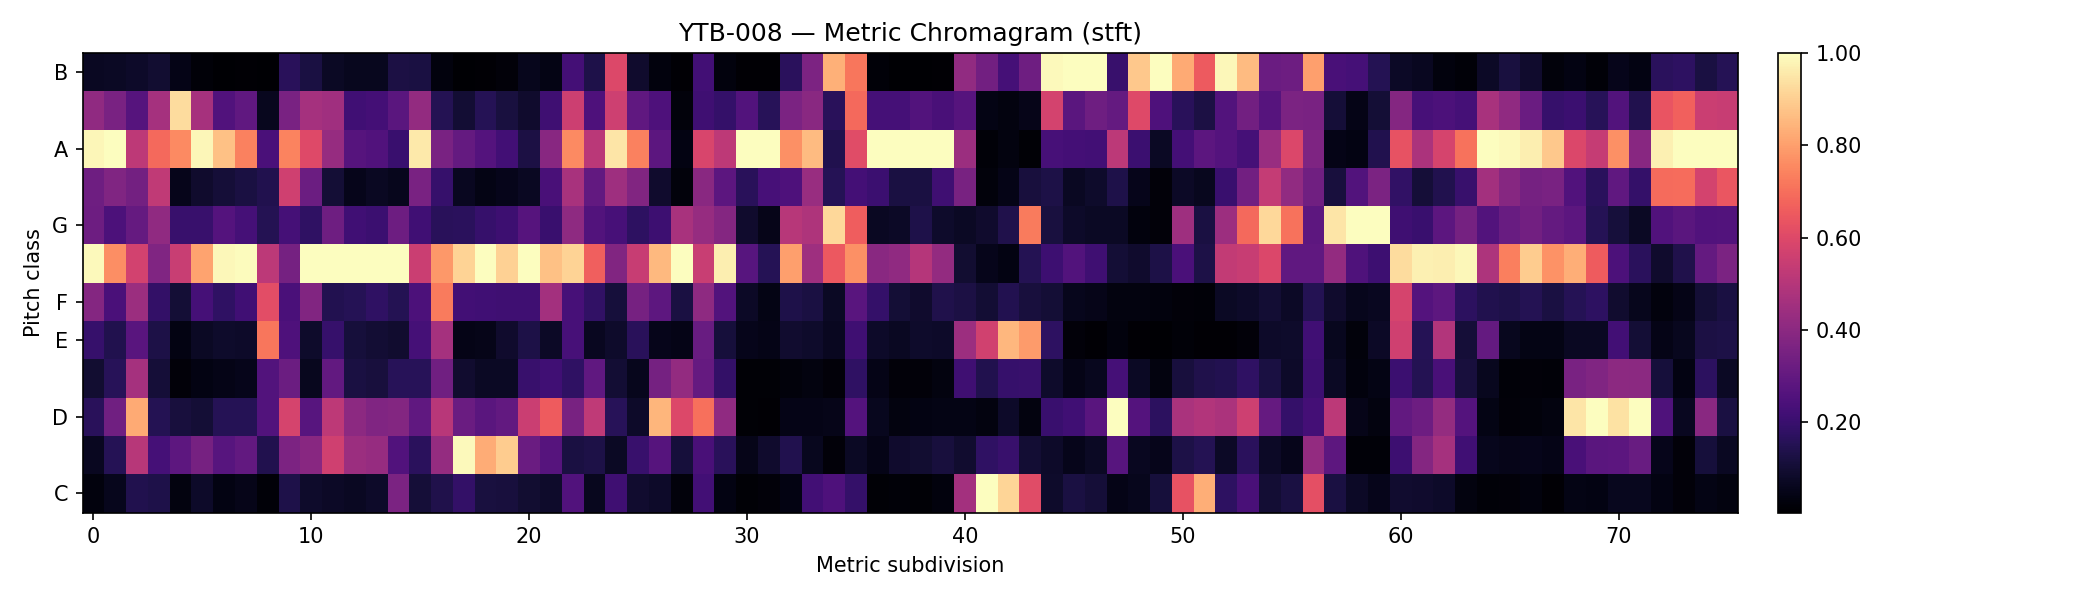

In [10]:
# Arguments + Run (edit this cell as needed)
TRACK_NAME = "YTB-008"
START_MARKER = "F1.A1"
END_MARKER = "F1.A2"

HOP_LENGTHS = (256,)
CHROMA_TYPES = ("cqt", "stft")
BPM_THRESHOLD = 180.0
AGGREGATE = "mean"
ACCENT_MODE = "preserve"

# Uses load_audio_region(...), which resolves marker names via resolve_audio_region.
sweep_results = sweep_chroma_tuning(
    track_name=TRACK_NAME,
    start_marker=START_MARKER,
    end_marker=END_MARKER,
    chroma_types=CHROMA_TYPES,
    hop_lengths=HOP_LENGTHS,
    bpm_threshold=BPM_THRESHOLD,
    aggregate=AGGREGATE,
    accent_mode=ACCENT_MODE,
)

sweep_results.keys()

In [11]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def _chroma_peakiness_score(C: np.ndarray, eps: float = 1e-12) -> float:
    """
    Score higher when chroma frames are more concentrated.
    Assumes C is nonnegative. If C is L1-normalized per frame, max(C) is in [1/12, 1].
    """
    # L1 normalize per frame for a fair comparison across tunings
    S = C.sum(axis=0, keepdims=True) + eps
    Cn = C / S
    return float(np.mean(np.max(Cn, axis=0)))

def sweep_chroma_tuning(
    y: np.ndarray,
    sr: int,
    *,
    chroma_type: str = "cqt",      # "cqt" or "stft"
    hop_length: int = 256,
    n_fft: int = 4096,             # used for stft
    bins_per_octave: int = 12,     # keep 12 if you want tuning=cents/100
    n_steps: int = 100,
    cents_range: float = 50.0,     # sweep +/- this many cents around center
    center_cents: float | None = None,  # if None, uses librosa.estimate_tuning
    show_plot: bool = True,
):
    """
    Returns:
      best: dict with best_cents, best_tuning, best_score, C_best
      results: dict with cents_grid, tuning_grid, scores
    """
    if center_cents is None:
        # librosa returns tuning in "fractional bins" (fraction of a semitone if bins_per_octave=12)
        est_tuning = float(librosa.estimate_tuning(y=y, sr=sr, bins_per_octave=bins_per_octave))
        center_cents = est_tuning * (1200.0 / bins_per_octave)  # bins_per_octave=12 -> *100 cents

    cents_grid = np.linspace(center_cents - cents_range, center_cents + cents_range, n_steps)
    tuning_grid = cents_grid / (1200.0 / bins_per_octave)  # 12 -> cents/100

    scores = np.empty_like(tuning_grid, dtype=np.float64)
    C_best = None
    best_idx = 0
    best_score = -np.inf

    for i, tuning in enumerate(tuning_grid):
        if chroma_type == "cqt":
            C = librosa.feature.chroma_cqt(
                y=y, sr=sr, hop_length=hop_length,
                bins_per_octave=bins_per_octave,
                tuning=float(tuning),
            )
        elif chroma_type == "stft":
            C = librosa.feature.chroma_stft(
                y=y, sr=sr, hop_length=hop_length,
                n_fft=n_fft,
                tuning=float(tuning),
            )
        else:
            raise ValueError('chroma_type must be "cqt" or "stft"')

        s = _chroma_peakiness_score(C)
        scores[i] = s
        if s > best_score:
            best_score = s
            best_idx = i
            C_best = C

    best = {
        "best_cents": float(cents_grid[best_idx]),
        "best_tuning": float(tuning_grid[best_idx]),
        "best_score": float(best_score),
        "C_best": C_best,
        "center_cents": float(center_cents),
    }
    results = {
        "cents_grid": cents_grid,
        "tuning_grid": tuning_grid,
        "scores": scores,
    }

    if show_plot:
        plt.figure()
        plt.plot(cents_grid, scores)
        plt.axvline(best["best_cents"])
        plt.title(f"Tuning sweep ({chroma_type}) score vs cents")
        plt.xlabel("cents offset (relative to A440)")
        plt.ylabel("peakiness score (higher = more concentrated chroma)")
        plt.show()

    return best, results

In [ ]:
# Arguments + Run (edit this cell as needed, then run only this cell)
TRACK_NAME = "YTB-008"
START_MARKER = "F1.A1"
END_MARKER = "F1.A2" 